<h1 style="margin-bottom: 0; text-align:center">
<b>
<font color="problue">
    AI61006 • <a href='https://prabhatkmishra.github.io/cps.html' style="color: inherit; text-decoration: none;" onmouseover="this.style.textDecoration='underline'" onmouseout="this.style.textDecoration='none'">AI for Cyber Physical Systems</a>
</font>
</b>
</h1>
<h2 style="margin-top: 0; text-align:center"><b>Spring 2026</b></h2>

<h1 style="text-align:center; font-weight: bold">Reinforcement Learning Tutorial</h1>

---

Reference: 
- https://huggingface.co/learn/deep-rl-course/en/unit1/rl-framework
- https://github.com/johnnycode8/gym_solutions

## Main hypothesis
All goals can be described as the maximization of the expected cumulative rewards

## Tasks
- **Episodic** :In a video game, the episode begins when a level starts and ends when the player is killed or completes the level.
- **Continuing**: Automated stock trading

# Two main approaches for solving RL problems

## Policy based method
Control, action, command, policy, input, stimuli, actuation refer to the same thing with sometime a slightly different meaning. Therefore, this is better to give a formal definition.
A policy $\pi$ is a map from state to action. 
- What is the meaning of policy in the context of PID control?
- What is the meaning of policy in the context of some optimization based control?
Policy-based methods learn this policy $\pi$.
The policy can also be defined as a probability distribution over the set of actions, which is represented as $\pi(a \mid s)$. 

## Value based method
Suppose you want to be a rich person, so marrying a rich person can also be an option. 
Bank robbery can also be an option if it is legal but it has more risk.
In value based method, the agent learns the value of states which are close to goal. 
For example, the state achieved by a bank robbery (action) may not have good value. The value of a state under a policy $\pi$ is given by 
\begin{equation*}
V_\pi(s) = E_\pi[R_{t+1} + \gamma R_{t+2} + \ldots \mid s_t =s].
\end{equation*}
- Example Q learning

# **Tutorial on Q Learning**
- model free learning (the AI agent need not to know the model of the environment)

**Reference** - https://gymnasium.farama.org/environments/classic_control/mountain_car

Importing required libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

Create the environment

In [13]:
env = gym.make('MountainCar-v0', render_mode="human")
env.reset()

(array([-0.56784445,  0.        ], dtype=float32), {})

In [14]:
env.close()

## **Goal**
The car is positioned in a valley between two mountains. The engine is not strong enough to drive up the steep right hill in a single pass. The agent must learn to drive back and forth to build up enough momentum to reach the flag on top of the right hill.

# Dynamics of the mountain car

$v_{t+1} = v_t + (a - 1)F - \cos(3x_t)g$

$x_{t+1} = x_t + v_{t+1}$, 
where
 - $x$: position
 - $v$: velocity
 - $a$: action
 - $F$: Force
 - $g$: gravity
 

# **Action Space** - Discrete(3). 
- 0: accelerate to the left
- 1: don't accelerate
- 2: accelerate to the right

- **Reward**: The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of $-1$ for each timestep.
- **Starting State**: The position of the car is assigned a uniform random value between $-0.6$ to $-0.4$. The starting velocity of the car is always assigned to 0.
- **Termination**: The position of the car is greater than or equal to $0.5$ (the goal position on top of the right hill)
- **Truncation**: The length of the episode is $200$.

# **State Space** - Continuous(2)
- $\text{state = [position, velocity]}$
- Here, state-space is same as the observation space (which means all states are observable)
- Run the following command to understand the bounds of the state-space

In [4]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


# Discretization of the state-space

In [5]:
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07
print(pos_space)

[-1.2        -1.1052632  -1.0105264  -0.9157895  -0.8210527  -0.72631586
 -0.631579   -0.5368421  -0.4421053  -0.34736848 -0.2526316  -0.15789473
 -0.06315792  0.0315789   0.12631583  0.22105265  0.31578946  0.41052628
  0.5052631   0.6       ]


# **$Q$ table**

- the environment has already defined upper and lower bounds of the state-space
- we need to discretize it to get a finite state-space

- We got a finite state space with $N = 20$

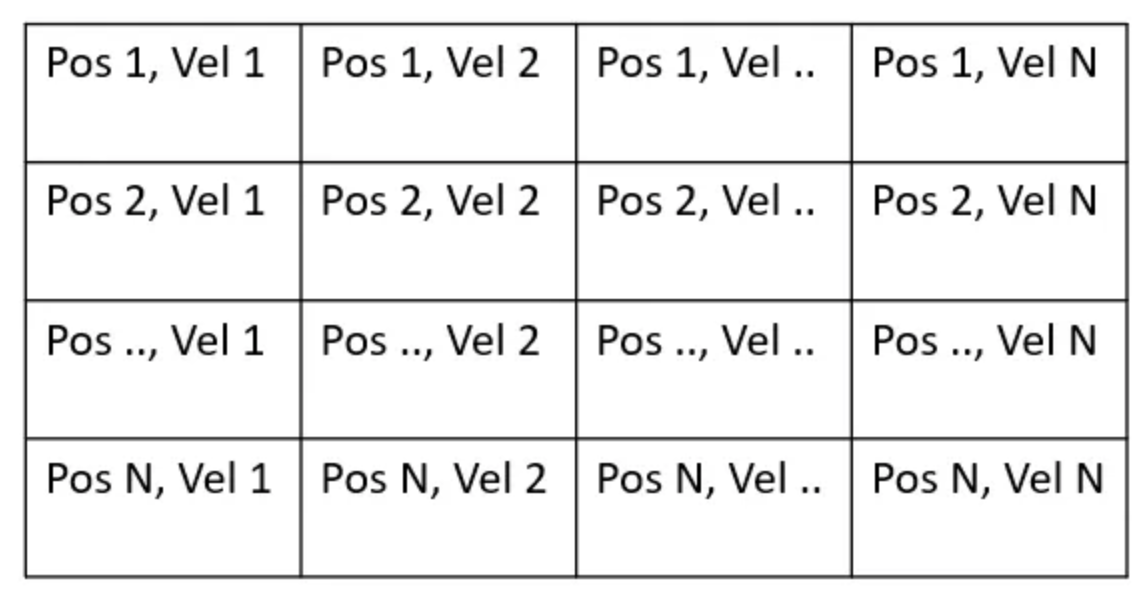

- the action space is already finite (it has only three elements)
- the shape of our state-action space is $20 \times 20 \times 3$
- Let us build a $Q$-table

# Initialize a $Q$-table with zeros

In [15]:
q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))

This q-table has $20\times  20 \times 3 = 1200$ values. Consider it like a look-up table. 
- Our mountain car is in one of the $400$ states and we will check which one of the three actions is good for it according to the table that we have. 
- We can also randomly initialized this table. 
- Assume that there exists some ideal table, which we can use to reach the flag.
- Since we do not have such table, we use $Q$-learning to learn that table.
- $Q$-learning is about learning Q-table.

# How to learn your Q-table
- The procedure is somewhat same as you learnt weights of a neural network but there is one difference that we do not have labelled data pairs. 
- Our agent will interact with the environment and learn through experience.
- Learning through experience is called Reinforcement Learning.
- The agent is exactly like you, students! You came to IIT and were looking for tasty options of food. You tried in different restaurants. Initially, you explored more. You started visiting your favourite restaurants untill you found the better one through exploration. This is called **exploration-exploitation trade-off**.
- In summary, you initialize the Q-table randomly and update it as you get more and more experience.

## Our Q-agent has a few more similarities with you!
- Each semester you say, let me explore new opportunities in campus (make new friends, participate in student gymkhana, sleep, play games, skip lectures, etc.) and I will study the next semester onwards. If studying is an optimal policy $\pi^\ast$, so value of a state $s$ under the optimal policy $\pi^\ast$ will be the optimal value $V^{\ast}_{\pi}(s)$.  
- In current semester, your state is $s_t$, you take action $a_t$ and you reach to a new state $s_{t+1}$ in the next semester. The reward of the current semester will be printed in your transcript in golden colors is $R_{t+1} = r(s_t, a_t)$. Here $r$ is a function that assigns a real value to each state-action pair. So your Q-table for each $(s_t, a_t)$ pair will look like
\begin{equation*}
Q_{\pi^\ast}(s_t, a_t) = r(s_t, a_t) + \gamma V_{\pi}^\ast(s_{t+1})
\end{equation*} 
- From the next semester onwards, you are planning to take the optimal policy $\pi^\ast$, which is the best among all possible policies. If you have chosen $a_t$ which maximizes your Q-value, you will get optimal V-value as well. 
\begin{equation}
V^\ast(s_{t}) = \max_a Q_{\pi^\ast}(s_{t}, a).
\end{equation}

# The update rule for the Q-agent

The update rule of Q function is inspired by the stochastic approximation technique that we discused in the class. It is very much intuitional as you can see below:
\begin{equation}
Q^{\text{new}}(s,a) = (1-\alpha) Q^{\text{old}}(s,a) + \alpha \times \text{update term},
\end{equation}
where $\alpha \in ]0,1[$ is called learning rate. 
- $\alpha = 0:$ do not change or learn
- $\alpha = 1:$ forget everything about past

Several different algorithms are developed by defining the update term differently. The update term is 
\begin{equation}
R_{t+1} + \gamma  V^\ast(s_{t+1}),
\end{equation}
here $\gamma \in ]0,1[$ is a discount factor. The choice of the discount factor helps you to get a balance between your current reward and future Q-function.

Therefore,

\begin{equation}
Q^{\text{new}}(s_t,a_t) = (1-\alpha) Q^{\text{old}}(s_t,a_t) + \alpha (R_{t+1} + \gamma V^\ast(s_{t+1})),
\end{equation}
which is the same as

\begin{equation}
Q^{\text{new}}(s_t,a_t) = Q^{\text{old}}(s_t,a_t) + \alpha (R_{t+1} + \gamma V^\ast(s_{t+1}) - Q^{\text{old}}(s_t,a_t)),
\end{equation}

We can write the code to update the Q table:

``` q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action] ```

# Q-Learning settings
- We can do reward shaping
- Initially we explore more and gradually start exploiting

In [16]:
learning_rate_a = 0.9    # alpha or learning rate
discount_factor_g = 0.9  # gamma or discount factor.

epsilon = 1         # 1 = 100% random actions, gradually we will decrease exploration and increase exploitation
# by using epsilon_decay_rate = 2/episodes # epsilon decay rate

# $Q$-**Learning Implementation**

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import platform
from tqdm import trange


def run(episodes, eps=1, is_training=True, render=False, student_name='anonymous'):
    # write name in the plot
    student_name = student_name.strip()
    if not student_name:
        print("Error: Name cannot be empty!")
        return

    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07

    # TRAINING
    if(is_training):
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # init a 20x20x3 array
    # TESTING
    else:
        f = open('mountain_car.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    # hyperparameters
    learning_rate_a = 0.9   # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor.

    epsilon = eps         # 1 = 100% random actions
    epsilon_decay_rate = 2/episodes # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in trange(episodes):
        state = env.reset()[0]      # Starting position, starting velocity always 0
        # convert continuous state to discrete state (position and velocity segments)
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards > -1000):

            # Epsilon-greedy action selection
            if is_training and rng.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, :])

            new_state,reward,terminated,_,_ = env.step(action)  # Take action and observe new state and reward
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            # Update Q table using Q-learning formula
            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards += reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        rewards_per_episode[i] = rewards

    env.close()

    # Save Q table to file
    if is_training:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = np.zeros(episodes)

    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])

    hostname = platform.platform()  # Computer name    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # plotting mean rewards per episode
    plt.title(f"Name: {student_name}\nTime: {timestamp}\n OS: {hostname}")    
    plt.xlabel("Episode")
    plt.ylabel("Mean Rewards (100 episode window)")
    plt.plot(mean_rewards)
    filename = f"RL_{student_name.replace(' ', '_')}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    

# **Training the Agent**
- I am using 5000 episodes for training. Since the rendering is false, you will not see any output.
- You may like to use less number of episodes to understand how much time it takes in your computer.

100%|██████████| 4000/4000 [00:34<00:00, 115.49it/s]


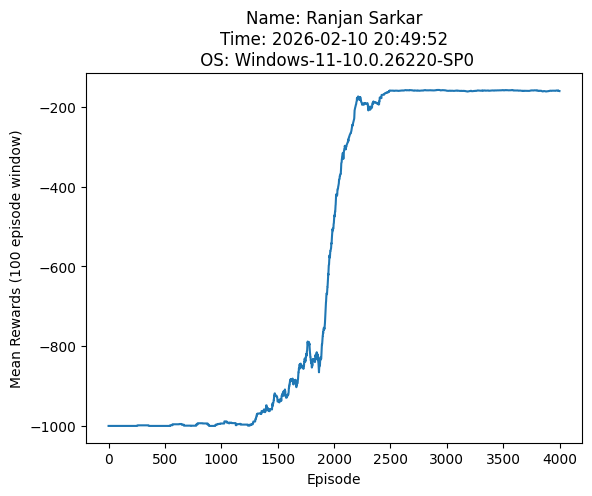

<Figure size 640x480 with 0 Axes>

In [9]:
name = input("Enter your name: ")
run(4000, is_training=True, render=False, student_name= name)

# **Testing**

Starting with exploration ($\epsilon$-greedy policy)

100%|██████████| 500/500 [00:00<00:00, 517.42it/s]


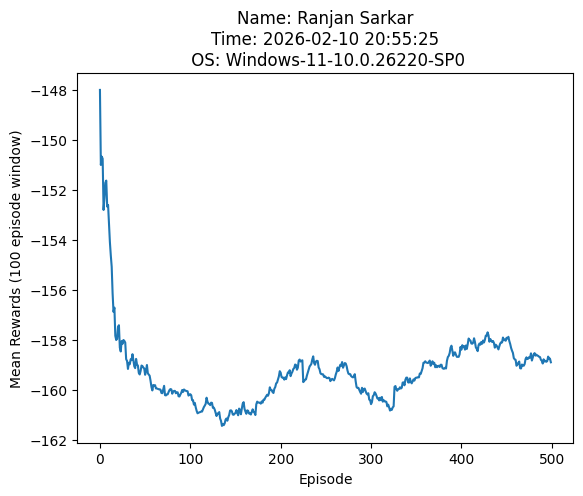

In [18]:
run(500, is_training=False, render=False, student_name= name)

***eps*** **= 0**: No exploration, Full exploitation

100%|██████████| 500/500 [00:00<00:00, 503.62it/s]


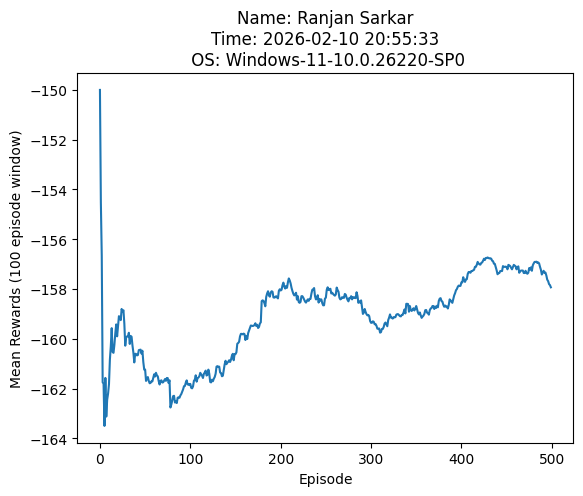

In [19]:
run(500, eps=0, is_training=False, render=False, student_name= name)